In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys

## Load in data that was generated from png plot digitizer
Didn't have raw data from Mitch's sims so I used an online plot digitizer tool that extracted the data from the png and converted a csv that I could read in. I then fit an polynomial to this to try to reduce some of the granular noise associated with the plot digitizing

In [2]:
data = np.genfromtxt('Linear_FR.csv',delimiter=',',
                     names = 'dphi, derr', dtype='f8')
data['derr'] *= 1e-3
err_lin = np.polyfit(data['dphi'],data['derr'],12)
pltphi = np.linspace(min(data['dphi']),max(data['dphi']),100)
dataNL = np.genfromtxt('NonLinear_FR.csv',delimiter=',',
                     names = 'dphi, derr', dtype='f8')
dataNL['derr'] *= 1e-3
err_nonlin = np.polyfit(dataNL['dphi'],dataNL['derr'],12)
pltphinl = np.linspace(min(dataNL['dphi']),max(dataNL['dphi']),100)

Plot what it looks like to compare it to the png: ![title](./Mitch_NL_Sim.png)

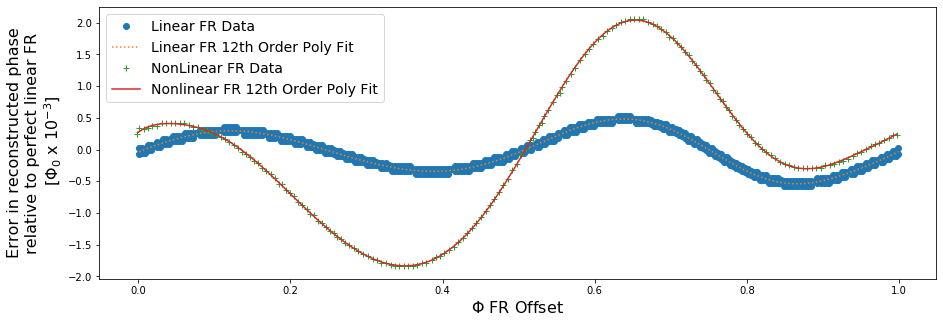

In [3]:
plt.figure(figsize = (15,5))
plt.plot(data['dphi'],data['derr']/1e-3,'o',
         color = 'C0', label = 'Linear FR Data')
plt.plot(pltphi,np.polyval(err_lin,pltphi)/1e-3,
         color = 'C1', ls = ':',label = 'Linear FR 12th Order Poly Fit')
plt.plot(dataNL['dphi'],dataNL['derr']/1e-3,'+',
         color='C2',label = 'NonLinear FR Data')
plt.plot(pltphinl,np.polyval(err_nonlin,pltphinl)/1e-3,
         color = 'C3',ls = '-',label = 'Nonlinear FR 12th Order Poly Fit')
plt.legend(fontsize = 14)
plt.xlabel('$\Phi$ FR Offset', fontsize = 16)
_ = plt.ylabel('Error in reconstructed phase\nrelative to perfect linear FR\n [$\Phi_0$ x 10$^{-3}$]', 
               fontsize = 16)

Now compute the derivative because 

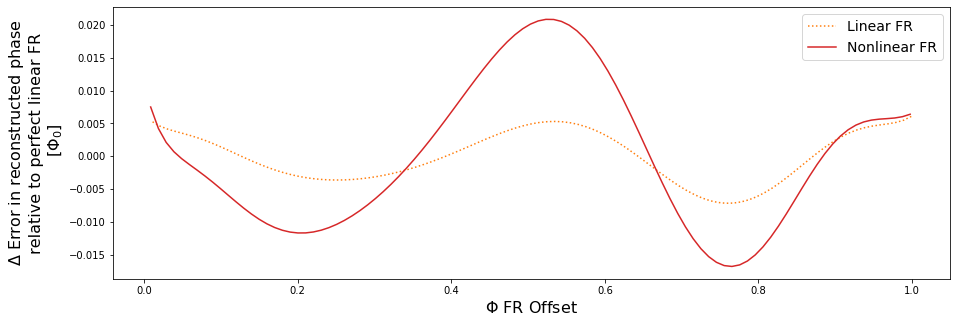

In [4]:
plt.figure(figsize = (15,5))
plt.plot(pltphi[1:],np.diff(np.polyval(err_lin,pltphi))/np.diff(pltphi),
         color = 'C1', ls = ':',label = 'Linear FR')
plt.plot(pltphinl[1:],np.diff(np.polyval(err_nonlin,pltphinl))/np.diff(pltphinl),
         color = 'C3',ls = '-',label = 'Nonlinear FR')
plt.legend(fontsize = 14)
plt.xlabel('$\Phi$ FR Offset', fontsize = 16)
_ = plt.ylabel('$\Delta$ Error in reconstructed phase\nrelative to perfect linear FR\n [$\Phi_0$]', 
               fontsize = 16)

Now import some constants that we need to do the conversions from $\phi_0$ -> $K_{cmb}$

In [5]:
#Constants:
kb = 1.380649e-23
c = 299792458.
h = 6.62607004e-43
Tcmb = 2.72548

To go from A -> W we need the bolometer responsivity, $S_i$. For $S_i$ I get these numbers from the detector target parameters document so we expect them to better reflect our yielded MF arrays. In general they're a bit higher than the $S_i$'s we've seen in lab so far.

In [6]:
P_Sat90 = 2.62e-12
P_gamma_typ = 1.4e-12
P_oper90 = P_Sat90 - P_gamma_typ
R_frac = 0.5
R_n = 8e-3
V_bias = np.sqrt(P_oper90*R_frac*R_n)
SI_90 = 1/(V_bias/1e-6)
print(f'Si = {np.round(SI_90,2)} 1/uV')

Si = 14.31 1/uV


Next need to go from W -> K we need to integrate our efficiency normalized bandpasses against a cmb blackbody this integral was ripped right out of the bolocalc paper/manual

In [7]:
def WperK(fin,bp):
    '''
    Converts K_cmb to Watts. Ripped from bolocalc manual.
    Arguments:
    fin (float arr) : Frequencies in GHz, must be equal length as bandpasses.
    bp (float arr) : Bandpass transmission normalized.
    
    Returns:
    Watts
    '''
    f = np.copy(fin)
    f *= 1e9
    prod = (np.exp(h*f/(kb*Tcmb)))*bp*(1/kb)*(h*f/(Tcmb*(np.exp(h*f/(kb*Tcmb)) - 1)))**2
    return sum(prod)*np.mean(np.diff(f))

Load in MF bandpass info from instrument model repo and plot what they look like for reference

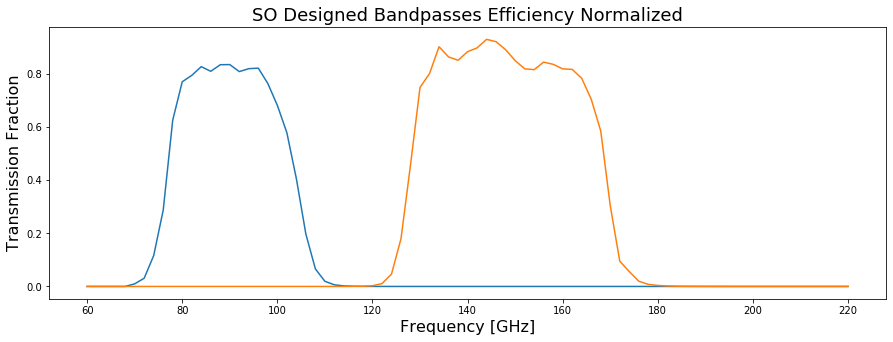

In [8]:
data = np.genfromtxt('/home/msilvafe/instrument_model/instrument_hardware/modeled_bandpasses/MF/MF_wOMT_wLPF_v1.txt',
             delimiter = '\t',dtype = ('f8','f8','f8'),names = True)
plt.figure(figsize = (15,5))
plt.title('SO Designed Bandpasses Efficiency Normalized',fontsize = 18)
plt.plot(data['Frequency_GHz'],data['90_GHz_transmission'])
plt.plot(data['Frequency_GHz'],data['150_GHz_transmission'])
plt.xlabel('Frequency [GHz]',fontsize = 16)
_ = plt.ylabel('Transmission Fraction', fontsize = 16)

Get the Kelvin to Watt conversion from these bandpasses

In [9]:
K2W90 = WperK(data['Frequency_GHz'],data['90_GHz_transmission'])
print(f'90 GHz is {np.round(K2W90/1e-12,2)} pW per K_CMB')
K2W150 = WperK(data['Frequency_GHz'],data['150_GHz_transmission'])
print(f'150 GHz is {np.round(K2W150/1e-12,2)} pW per K_CMB')

90 GHz is 0.31 pW per K_CMB
150 GHz is 0.49 pW per K_CMB


Define some additional very simple conversion functions

In [10]:
def phi_to_pA(phi):
    '''
    Input 
    phi : flux in phi0
    Output 
    pA : TES current in pA
    '''
    return phi*9e6

def pA_to_W(pA, si):
    '''
    Input
    pA : TES current in pA
    si : bolometer responsivity in 1/uV (or equivalently uA/pW)
    Output
    W : Power on the bolometer in watts
    '''
    pA *= 1e-6 # pA -> uA
    return (pA/si)*1e-12 #converts output to W from pW

def W_to_K(W, k2w):
    '''
    Input
    W : Power on bolometer in watts
    k2w : Conversion from Watts to K_CMB from integrating properly efficiency weighted bandpasses
        by a CMB temperature blackbody spectrum.
    Output
    K : Effective signal on bolometer in K_CMB
    '''
    return W/k2w

def dphi_2_dK(phi0, si, k2w):
    '''
    Input
    phi0 : Signal measured in squid in units of flux quanta (2pi per radian)
    si : bolometer responsivity in 1/uV (or equivalently uA/pW)
    k2w : Conversion from Watts to K_CMB from integrating properly efficiency weighted bandpasses
        by a CMB temperature blackbody spectrum.
    Output
    K : Effective signal on bolometer in K_CMB given a measured flux in squid = phi0
    '''
    pA_per_phi0 = phi_to_pA(phi0)
    W_per_phi0 = pA_to_W(pA_per_phi0, si)
    K_per_phi0 = W_to_K(W_per_phi0, k2w)
    return K_per_phi0

Now just convert the x-axis of the above plot in terms of $\Phi_0$ -> $K_{cmb}$

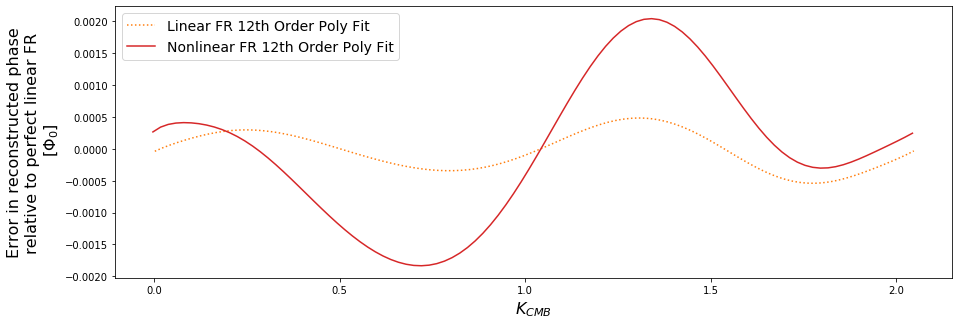

In [11]:
plt.figure(figsize = (15,5))
plt.plot(dphi_2_dK(pltphi,SI_90,K2W90),np.polyval(err_lin,pltphi),
         color = 'C1', ls = ':',label = 'Linear FR 12th Order Poly Fit')
plt.plot(dphi_2_dK(pltphinl,SI_90,K2W90),np.polyval(err_nonlin,pltphinl),color = 'C3',ls = '-',label = 'Nonlinear FR 12th Order Poly Fit')
plt.legend(fontsize = 14)
plt.xlabel('$K_{CMB}$', fontsize = 16)
_ = plt.ylabel('Error in reconstructed phase\nrelative to perfect linear FR\n [$\Phi_0$]', fontsize = 16)

In [19]:
def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

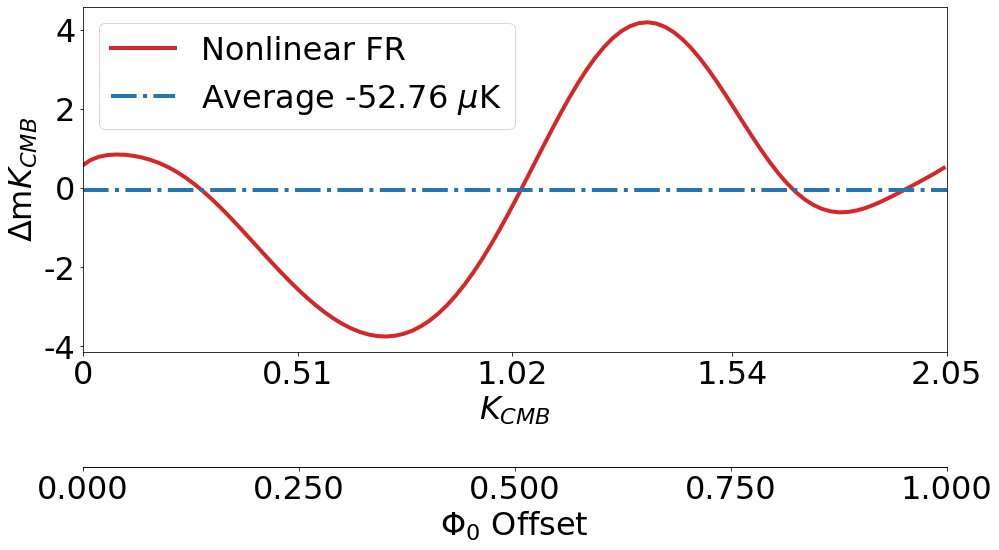

In [60]:
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_axes((0.1,0.3,0.8,0.6))
#plt.plot(dphi_2_dK(pltphi,SI_90,K2W90),dphi_2_dK(np.polyval(err_lin,pltphi)/1e-3, SI_90, K2W90),
#         color = 'C1', ls = ':',label = 'Linear FR 12th Order Poly Fit')
ax1.plot(dphi_2_dK(pltphinl,SI_90,K2W90),dphi_2_dK(np.polyval(err_nonlin,pltphinl)/1e-3, SI_90, K2W90),
         color = 'C3',ls = '-',label = 'Nonlinear FR',lw = 4)
pltmean = np.mean(dphi_2_dK(np.polyval(err_lin,pltphi)/1e-3, SI_90, K2W90))
ax1.axhline(pltmean,label = f'Average {np.round(pltmean/1e-3,2)} $\mu$K',
           color = 'C0', ls = '-.',lw = 4)
ax1.legend(fontsize = 32)
ax1.set_xlabel('$K_{CMB}$', fontsize = 32)
ax1.set_ylabel('$\Delta$m$K_{CMB}$', fontsize = 32)
ax1.set_xticks([0,np.round(2.05/4,2),
                     np.round(2*2.05/4,2),
                     np.round(3*2.05/4,2),2.05])
ax1.set_xticklabels([0,np.round(2.05/4,2),
                     np.round(2*2.05/4,2),
                     np.round(3*2.05/4,2),2.05],
                    fontsize = 32)
ax1.set_xlim(0,2.05)
ax1.set_yticks([-4,-2,0,2,4])
ax1.set_yticklabels([-4,-2,0,2,4],fontsize = 32)

ax2 = fig.add_axes((0.1,0.1,0.8,0.0))
ax2.yaxis.set_visible(False) # hide the yaxis

new_tick_locations = np.array([0,2.05/4,2*2.05/4,3*2.05/4,2.05])

def tick_function(X):
    V = X/2.05
    return ["%.3f" % z for z in V]

ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations),
                   fontsize = 32)
ax2.set_xlabel(r"$\Phi$$_0$ Offset",fontsize = 32)
plt.show()

In [13]:
np.mean(dphi_2_dK(np.polyval(err_lin,pltphi)/1e-3, SI_90, K2W90))

-0.05276159805696563

For reference here's the end-end number for $phi_0$ -> $K_{cmb}$

In [15]:
KCMBperPhi090 = dphi_2_dK(1,SI_90,K2W90)
#KCMBperPhi0150 = dphi_2_dK(1,SI_150,K2W150)
print(f'90 GHz Kelvin per 1 $\Phi_0$ : {np.round(KCMBperPhi090,2)}')
#print(f'150 GHz Kelvin per 1 $\Phi_0$ : {np.round(KCMBperPhi0150,2)}')

90 GHz Kelvin per 1 $\Phi_0$ : 2.05


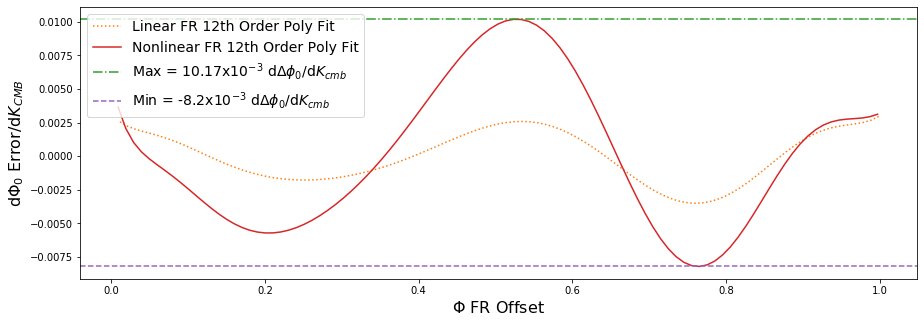

In [16]:
plt.figure(figsize = (15,5))
plt.plot(pltphi[1:],
         np.diff(np.polyval(err_lin,pltphi))/np.diff(dphi_2_dK(pltphi,SI_90,K2W90)),color = 'C1', ls = ':',label = 'Linear FR 12th Order Poly Fit')
plt.plot(pltphinl[1:],
         np.diff(np.polyval(err_nonlin,pltphinl))/np.diff(dphi_2_dK(pltphinl,SI_90,K2W90)),color = 'C3',ls = '-',label = 'Nonlinear FR 12th Order Poly Fit')

plt.xlabel('$\Phi$ FR Offset', fontsize = 16)
plt.ylabel('d$\Phi_0$ Error/d$K_{CMB}$', fontsize = 16)
maxval = np.max(np.diff(np.polyval(err_nonlin,pltphinl))/np.diff(dphi_2_dK(pltphinl,SI_90,K2W90)))
plt.axhline(maxval,
           label = f'Max = {np.round(maxval/1e-3,2)}x10'+'$^{-3}$ d$\Delta$$\phi_0$/d$K_{cmb}$',ls = '-.',color = 'C2')
minval = np.min(np.diff(np.polyval(err_nonlin,pltphinl))/np.diff(dphi_2_dK(pltphinl,SI_90,K2W90)))
plt.axhline(minval,
           label = f'Min = {np.round(minval/1e-3,2)}x10'+'$^{-3}$ d$\Delta$$\phi_0$/d$K_{cmb}$',ls = '--',color = 'C4')
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.patch.set_facecolor('white')